In [1]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask

# =========================
# 1) RUTAS (AJUSTA SOLO AQUÍ)
# =========================

# shapefile (parcelas)
shapefile_path = r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\metadata\plot_shapefile.shp"

# tus 5 ortomosaicos por banda (ya los tienes)
band_paths = {
    "B":   r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\drone_data\F10122025\BANDAS\20251210_B.tif",
    "G":   r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\drone_data\F10122025\BANDAS\20251210_G.tif",
    "R":   r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\drone_data\F10122025\BANDAS\20251210_R.tif",
    "RE":  r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\drone_data\F10122025\BANDAS\20251210_RE.tif",
    "NIR": r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\drone_data\F10122025\BANDAS\20251210_NIR.tif"
}

# salida
out_dir = r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\plots_stack_20251210"
os.makedirs(out_dir, exist_ok=True)

# orden fijo de bandas (IMPORTANTE para el proyecto)
band_order = ["B", "G", "R", "RE", "NIR"]

# NoData que usaremos en outputs
OUT_NODATA = -9999.0


# =========================
# 2) LEER SHAPEFILE + plot_id
# =========================
gdf = gpd.read_file(shapefile_path)

# CRS objetivo
target_crs = "EPSG:32631"
if gdf.crs is None:
    raise ValueError("El shapefile no tiene CRS definido. Defínelo en QGIS (EPSG:32631) y reintenta.")
if gdf.crs.to_string() != target_crs:
    gdf = gdf.to_crs(target_crs)

# plot_id (tu shapefile usa obsUnitId)
if "obsUnitId" in gdf.columns:
    gdf["plot_id"] = gdf["obsUnitId"]
elif "new_id" in gdf.columns:
    gdf["plot_id"] = gdf["new_id"]
elif "new_id2" in gdf.columns:
    gdf["plot_id"] = gdf["new_id2"]
else:
    gdf["plot_id"] = range(1, len(gdf) + 1)

print("CRS shapefile:", gdf.crs)
print("Parcelas:", len(gdf), " | plot_id únicos:", gdf["plot_id"].nunique())


# =========================
# 3) CHEQUEO: que todas las bandas tengan mismo CRS/shape
# =========================
ref_meta = None
for b in band_order:
    with rasterio.open(band_paths[b]) as src:
        meta = (src.crs, src.transform, src.width, src.height, src.dtypes[0], src.nodata)
        if ref_meta is None:
            ref_meta = meta
            print("Referencia:", b, "| CRS:", src.crs, "| size:", src.width, "x", src.height, "| nodata:", src.nodata)
        else:
            if meta[0] != ref_meta[0] or meta[1] != ref_meta[1] or meta[2] != ref_meta[2] or meta[3] != ref_meta[3]:
                raise ValueError(f"La banda {b} NO está alineada con la referencia. Deben tener mismo CRS/transform/shape.")

print("OK: Las 5 bandas están alineadas.")


# =========================
# 4) RECORTAR POR PARCELA Y GUARDAR STACK (5 bandas) POR PARCELA
# =========================
saved = 0

for i, row in gdf.iterrows():
    pid = int(row["plot_id"])
    geom = [row.geometry]  # rasterio.mask necesita lista
    
    clipped_list = []
    out_transform = None
    
    # recortar cada banda por la misma geometría
    for b in band_order:
        with rasterio.open(band_paths[b]) as src:
            # mask -> devuelve (bands, rows, cols). Aquí cada tif es 1 banda.
            arr, tr = mask(src, geom, crop=True, filled=True, nodata=OUT_NODATA)
            clipped_list.append(arr[0].astype(np.float32))  # arr[0] = banda 2D
            out_transform = tr
            out_crs = src.crs
    
    # stack final (5, H, W)
    stacked = np.stack(clipped_list, axis=0).astype(np.float32)
    
    # guardar
    out_path = os.path.join(out_dir, f"plot_{pid}_stack.tif")
    
    height, width = stacked.shape[1], stacked.shape[2]
    meta = {
        "driver": "GTiff",
        "height": height,
        "width": width,
        "count": stacked.shape[0],
        "dtype": "float32",
        "crs": out_crs,
        "transform": out_transform,
        "nodata": OUT_NODATA,
        "compress": "DEFLATE"
    }
    
    with rasterio.open(out_path, "w", **meta) as dst:
        dst.write(stacked)
    
    saved += 1
    
    # progreso cada 20
    if saved % 20 == 0:
        print(f"Guardados {saved}/{len(gdf)} ...")

print("LISTO ✅ Guardados:", saved, "archivos en:", out_dir)
print("Ejemplo:", os.path.join(out_dir, f"plot_{int(gdf.iloc[0]['plot_id'])}_stack.tif"))


CRS shapefile: EPSG:32631
Parcelas: 202  | plot_id únicos: 202
Referencia: B | CRS: EPSG:32631 | size: 14944 x 15790 | nodata: -3.4028234663852886e+38
OK: Las 5 bandas están alineadas.
Guardados 20/202 ...
Guardados 40/202 ...
Guardados 60/202 ...
Guardados 80/202 ...
Guardados 100/202 ...
Guardados 120/202 ...
Guardados 140/202 ...
Guardados 160/202 ...
Guardados 180/202 ...
Guardados 200/202 ...
LISTO ✅ Guardados: 202 archivos en: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\plots_stack_20251210
Ejemplo: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\plots_stack_20251210\plot_193_stack.tif


Bandas: 5 shape: 309 309 nodata: -9999.0


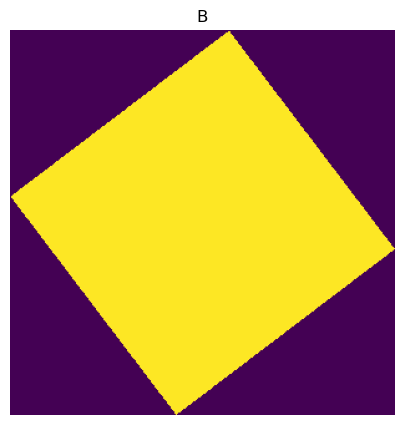

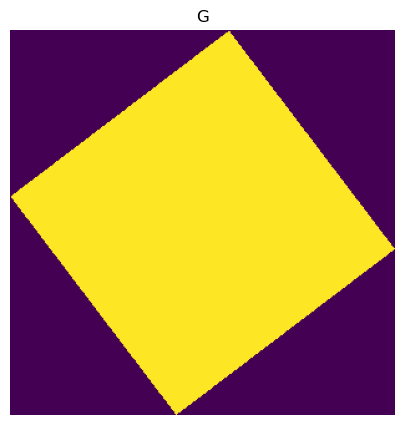

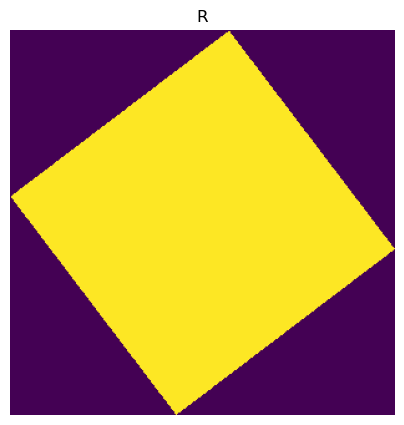

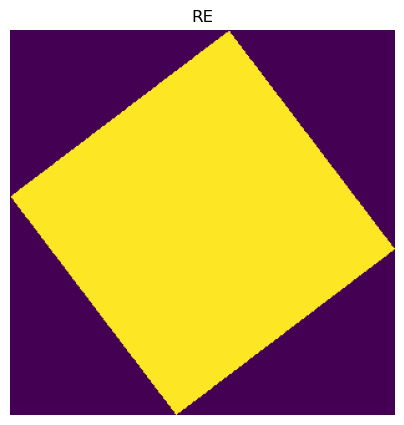

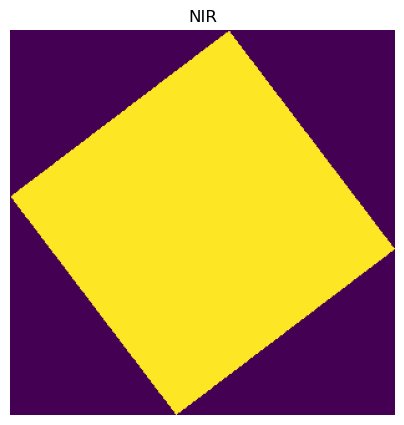

In [2]:
import rasterio
import matplotlib.pyplot as plt

test_plot = 193
test_path = os.path.join(out_dir, f"plot_{test_plot}_stack.tif")

with rasterio.open(test_path) as src:
    print("Bandas:", src.count, "shape:", src.height, src.width, "nodata:", src.nodata)
    img = src.read()  # (5,H,W)

for k, name in enumerate(["B","G","R","RE","NIR"]):
    plt.figure(figsize=(5,5))
    plt.imshow(img[k], vmin=np.nanpercentile(img[k],2), vmax=np.nanpercentile(img[k],98))
    plt.title(name)
    plt.axis("off")
    plt.show()
